In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
seed = 42
np.random.seed(seed)
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import cvxopt
import autograd
import autograd.numpy as np
import domain_adapt.domain_adapt.new.fxns as fxns
import domain_adapt.domain_adapt.new.utils as utils
import domain_adapt.domain_adapt.new.optimizers as optimizers
import domain_adapt.domain_adapt.SDR_data as data

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
# test weighted least squares b_opt by comparing with sklearn

np.random.seed(42)
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 15
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)

B = utils.ortho(np.array([[1.,2.]]).T)
ws_train = np.random.uniform(size=num_train)
#ws_train = np.ones(shape=15)

from sklearn.linear_model import Ridge
c = .0001
clf = Ridge(alpha=c, fit_intercept=False)
clf.fit(np.dot(xs_train, B), ys_train, sample_weight=ws_train)
sklearn_b_opt = clf.coef_
print 'sklearn_b_opt', clf.coef_
print ws_train
b_opt = fxns.weighted_lsqr_b_opt(B, xs_train, ys_train, ws_train)
print 'my b_opt', b_opt
assert np.linalg.norm(b_opt-clf.coef_) < 0.001

sklearn_b_opt [-0.2472514]
[ 0.892559    0.53934224  0.80744016  0.8960913   0.31800347  0.11005192
  0.22793516  0.42710779  0.81801477  0.86073058  0.00695213  0.5107473
  0.417411    0.22210781  0.11986537]
my b_opt [-0.24725453]


In [4]:
# test gradient of composed weighted_lsqr_loss

weighted_lsqr_loss_fxn = fxns.two_step(\
                                       g=fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_b_opt),\
                                       h=fxns.fxn.autograd_fxn(_val=fxns.weighted_squared_loss_given_b_opt),\
                                       g_argnums=(0,1,2,3),\
                                       h_argnums=(0,1,2,3),\
                                       )

np.random.seed(42)
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 15
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)
B = utils.ortho(np.array([[1.,2.]]).T)
ws_train = np.random.uniform(size=num_train)

weighted_lsqr_loss_fxn.grad_check(B, xs_train, ys_train, ws_train, care_argnums=(0,))

anal_grad (2, 1)
[[-0.69035428]
 [ 0.34517714]]
numerical_grad (2, 1)
[[-0.6866309 ]
 [ 0.34226873]]
error 0.00472465514768


In [11]:
# test gradient of b_opt, ws -> least squares loss of predicting losses due to b_opt

weighted_lsqr_loss_loss_fxn =\
    fxns.weighted_lsqr_loss_loss_fxn(g=fxns.fxn.autograd_fxn(_val=fxns.b_opt_to_squared_losses),\
                                     h=fxns.weighted_lsqr_loss_fxn(\
                                                                    g=fxns.fxn.autograd_fxn(_val=fxns.weighted_lsqr_b_opt),\
                                                                    h=fxns.fxn.autograd_fxn(_val=fxns.weighted_squared_loss_given_b_opt),\
                                                                    g_argnums=(0,1,2,3),\
                                                                    h_argnums=(0,1,2,3),\
                                                                    g_val_h_argnum=4,\
                                                                    ),\
                                     g_argnums=(0,1,2,4),\
                                     h_argnums=(0,1,3),\
                                     g_val_h_argnum=2\
                                     )

np.random.seed(42)
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 15
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)
B = utils.ortho(np.array([[1.,2.]]).T)
ws_train = np.random.uniform(size=num_train)
b_opt = fxns.weighted_lsqr_b_opt(B, xs_train, ys_train, ws_train)

weighted_lsqr_loss_loss_fxn.grad_check(B, xs_train, ys_train, ws_train, b_opt, care_argnums=(0,))

anal_grad (2, 1)
[[-0.23117156]
 [ 0.31850578]]
numerical_grad (2, 1)
[[-0.23097997]
 [ 0.31867911]]
error 0.000258354662221


In [12]:
# test upper bound term gradient
upper_bound_fxn =\
    fxns.upper_bound(\
                     g=fxns.fxn.autograd_fxn(_val=fxns.expected_conditional_PE_dist),\
                     h=weighted_lsqr_loss_loss_fxn,\
                     g_argnums=(5,3),\
                     h_argnums=(0,1,2,3,4)\
                     )

np.random.seed(42)
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 15
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)
B = utils.ortho(np.array([[1.,2.]]).T)
ws_train = np.random.uniform(size=num_train)
ws_full_train = np.random.uniform(size=num_train)
b_opt = fxns.weighted_lsqr_b_opt(B, xs_train, ys_train, ws_train)

upper_bound_fxn.grad_check(B, xs_train, ys_train, ws_train, b_opt, ws_full_train, care_argnums=(3,))

[ -5.95132696e-02  -2.02381487e+00   1.37347639e+00   1.12627489e+00
  -3.16682800e+00  -7.29298456e+00  -1.42463667e+01  -4.01472462e+00
  -7.35572137e-02  -3.33004071e-02  -1.48075810e+03   7.64776135e-01
  -4.08357031e-03  -1.38055943e+00   3.53682155e+01] asdf
anal_grad (15,)
[ -5.95132696e-02  -2.02381487e+00   1.37347639e+00   1.12627489e+00
  -3.16682800e+00  -7.29298456e+00  -1.42463667e+01  -4.01472462e+00
  -7.35572137e-02  -3.33004071e-02  -1.48075810e+03   7.64776135e-01
  -4.08357031e-03  -1.38055943e+00   3.53682155e+01]
numerical_grad (15,)
[ -5.95006600e-02  -2.02338927e+00   1.37348844e+00   1.12626691e+00
  -3.16563898e+00  -7.28526222e+00  -1.42400852e+01  -4.01378486e+00
  -7.35480594e-02  -3.32784436e-02  -1.45976070e+03   7.64802180e-01
  -4.08209214e-03  -1.37813448e+00   3.53732666e+01]
error 20.9974024693


AssertionError: 

In [16]:
# test total objective given b_opt, ws
objective_given_b_opt_ws =\
    fxns.sum(fs=[\
                 fxns.fxn.autograd_fxn(_val=fxns.weighted_squared_loss_given_b_opt),\
                 upper_bound_fxn,\
                 ],\
             fs_argnums=[\
                         (0,1,2,3,4),\
                         (0,1,2,3,4,5)
                        ]\
             )

np.random.seed(42)
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 15, 15
xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)
B = utils.ortho(np.array([[1.,2.]]).T)
ws_train = np.random.uniform(size=num_train)
ws_full_train = np.random.uniform(size=num_train)
b_opt = fxns.weighted_lsqr_b_opt(B, xs_train, ys_train, ws_train)

objective_given_b_opt_ws.grad_check(B, xs_train, ys_train, ws_train, b_opt, ws_full_train, care_argnums=(0,))

anal_grad (2, 1)
[[-0.8999947 ]
 [ 0.63401755]]
numerical_grad (2, 1)
[[-0.89978348]
 [ 0.63421024]]
error 0.000285910691086


[ 1.5]


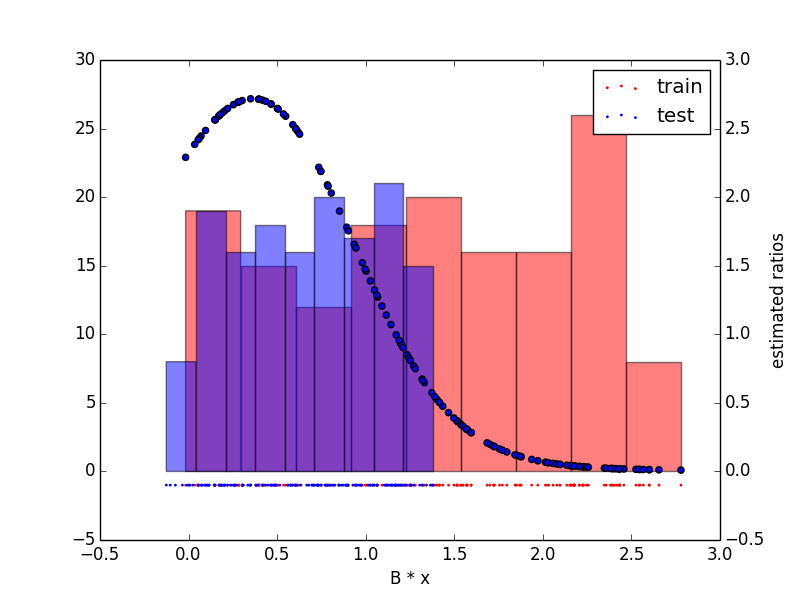

In [94]:
# test logreg ratio

# get data
random_data = data.random_data(x_dim=2, shift=1.)
num_train, num_test = 150, 150
#xs_train, xs_test, ys_train, ys_test = random_data.sample(num_train=num_train, num_test=num_test)
xs_train, xs_test, ys_train, ys_test = data.why_weighting_is_important_data(x_dim=2, num_train=num_train, num_test=num_test)

# 
#w_max = 10
#eps = 0.001
logreg_ratio_objective = fxns.logreg_ratio_objective.autograd_fxn()
dlogreg_ratio_objective_db = fxns.dopt_objective_dx.autograd_fxn(logreg_ratio_objective)
damp = .1
def lstsq_solver(A,b): 
    ans = scipy.sparse.linalg.lsmr(A, b, damp=damp)
    print ans, 'end'
    return ans[0]
#lstsq_solver = lambda A,b: scipy.sparse.linalg.lsmr(A, b, damp=damp)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
lsmr_solver = None
lin_solver = cg_solver
b_opt_given_B_fxn = fxns.cvx_opt(lin_solver=lin_solver, objective=logreg_ratio_objective, dobjective_dx=dlogreg_ratio_objective_db)

logreg_ratios_fxn = \
    fxns.two_step(\
                      g=b_opt_given_B_fxn,\
                      h=fxns.fxn.autograd_fxn(_val=fxns.b_to_logreg_ratios),\
                      g_argnums=(0,1,2,3),\
                      h_argnums=(0,1,2,3),\
                      g_val_h_argnum=0,\
                      )

sigma = np.array([1.5])
print sigma
B = utils.ortho(np.array([[1.,2.]]).T)
#b_opt = b_opt_given_B_fxn.val(xs_train, xs_test, sigma, B)

                      
#logreg_ratios_fxn.grad_check(xs_train, xs_test, sigma, B, care_argnums=(3,))
ratios = logreg_ratios_fxn.val(xs_train, xs_test, sigma, B)

fig, ax = plt.subplots()
data.data.plot_us(B, xs_train, xs_test, ax)
ratio_ax = ax.twinx()
ratio_ax.scatter(np.dot(xs_train,B), ratios)
ratio_ax.set_ylabel('estimated ratios')
basic.display_fig_inline(fig)